In [1]:
""" How to use C3D network. """
import numpy as np
import cv2
#import cv
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from tqdm import tqdm
from C3D_model import C3D
%matplotlib inline

In [2]:

def get_sport_clip(clip_name, verbose=True):
    """
    Loads a clip to be fed to C3D for classification.
    TODO: should I remove mean here?
    
    Parameters
    ----------
    clip_name: str
        the name of the clip (subfolder in 'data').
    verbose: bool
        if True, shows the unrolled clip (default is True).
    Returns
    -------
    Tensor
        a pytorch batch (n, ch, fr, h, w).
    """
    #print(clip_name)
    clip = sorted(glob(join( clip_name, '*.png')))
#     for f in clip:
#         print(f)
#     fs=[]
#     for frame in clip:
#         frame = io.imread(frame)
#         result = np.zeros(frame.shape,dtype=np.float32)
#         cv2.normalize(frame,result,0,1,cv2.NORM_MINMAX)
#         fs.append([resize(result, output_shape=(112, 200),
#                             preserve_range=True) ])
#     clip = np.array(fs)
    #print(clip)
    clip = np.array([resize(io.imread(frame),
                            output_shape=(112, 200),
                            preserve_range=True,
                            mode='constant') for frame in clip])
    clip = clip[:, :, 44:44+112, :]  # crop centrally

    if verbose:
        clip_img = np.reshape(clip.transpose(1, 0, 2, 3),(112, 41 * 112, 3))
#         plt.imshow(clip_img.astype(np.uint8))
#         plt.show()

    clip = clip.transpose(3, 0, 1, 2)  # ch, fr, h, w
    clip = np.expand_dims(clip, axis=0)  # batch axis
    clip = np.float32(clip)

    return torch.from_numpy(clip)




In [3]:
import scipy.io as scio
data = scio.loadmat('save.mat')
allX=data['xTrain']
allY=data['yTrain']
testX=data['xTest']
testY=data['yTest']

In [27]:
net = C3D()
device=torch.device('cuda:1')
net.to(device)
net.load_state_dict(torch.load('./myC3D.pickle'))
net.eval()


C3D(
  (features): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace)
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace)
    (8): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU(inplace)
    (10): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (12): ReLU(inplace)
    (13): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (14): ReLU(inplace)
    (15): MaxP

In [32]:
testX=allX
testY=allY

In [33]:
import gc
testX=torch.from_numpy(np.array(testX)).type(torch.float)

testX = Variable(testX)
testX = testX.cuda(1)



In [34]:
torch.cuda.empty_cache()
gc.collect()
testLoss=[]
predictions=[]
for i in range(0,len(testX),1):
    
    prediction = net.predict(testX[i:i+1])
#     print(prediction)
#     print(testY[i])
#     print()
    predictions.append(prediction.data.cpu().numpy())
    #print(Variable(prediction))
    #print(Variable(y))
#     loss = criterion(prediction,testY[i:i+2].squeeze())
#     testLoss.append(loss.item())

#     print(d,loss.item())


In [35]:
print(len(predictions))
error = 0
for i in range(len(predictions)):
    if predictions[i]!=testY[i]:
        error+=1
print(1-error/len(predictions))

666
1.0


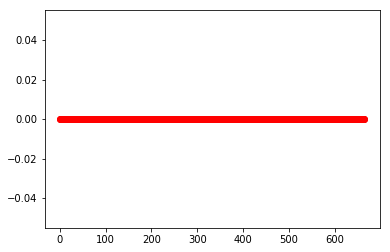

In [36]:
plt.figure()
plt.plot(range(len(predictions)),predictions-testY,'ro')
# plt.plot(range(len(testY)),,'bx')

plt.show()

In [31]:
torch.save(net.state_dict(),'./myC3D924.pickle')